# Notebook for Ixetl

* ```Purpose :```  Computes the time mean of ESTD (daily data, no filtering) and then compute the first timestep  at which this value is reached at each gridpoint. + Plot examples.

* ``` Inputfiles:``` This notebook works on this file (on CAL1): ```/mnt/meom/workdir/lerouste/GOM_1D/ENSTAT50_GOM025-GSL301.050_y1993-2012.1d_ssh.nc```
This file was computed on CAL1 with the cdftool ```cdfenstat```. The shell script is given below too.

* ```Author  :``` stephanie.leroux@ocean-next.fr

* ```Date    :``` jul 2019   

### Shell script

Shell script used to compute file ```/mnt/meom/workdir/lerouste/GOM_1D/ENSTAT50_GOM025-GSL301.050_y1993-2012.1d_ssh.nc``` on CAL1:

```
#!/usr/bin/env bash

ulimit -s unlimited

diro="/mnt/meom/workdir/lerouste/GOM_1D"
diri="/mnt/meom/workdir/garcia/DATA/GOM_1D"



cd ${diro}

#============== Extract ssh only ===========================
for im in {001..050}
do
  ncks -v ssh ${diri}/GOM025-GSL301.${im}_y1993-2012.1d_gridT.nc ${diro}/GOM025-GSL301.${im}_y1993-2012.1d_ssh.nc
done

#============== Run cdfenstat on all the 50 files ===========================
# takes ~5 min
cdfenstat -l GOM025-GSL301.0??_y1993-2012.1d_ssh.nc  -o ENSTAT50_GOM025-GSL301.050_y1993-2012.1d_ssh.nc -nc4

```

### Load modules

In [9]:
## standart libraries
import os,sys
import numpy as np

from scipy.signal import argrelmax

# xarray
import xarray as xr

import pandas as pd


# plot
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
import cmocean

import xarray as xr

# My custom module with plot tools for geographical maps
import wip_utils_SLX_plots_onw as slx 

# My custom module dealing with data on the MEOM server
import SLX_tools as slxtools

%matplotlib inline 

### Parameters

In [14]:
diri = "/mnt/meom/workdir/lerouste/GOM_1D/"

CONFIGCASE ='GOM025-GSL301'
suffix = 'y1993-2012.1d_ssh.nc'
varna='ssh'

diro = "./"

fili = "ENSTAT50_GOM025-GSL301.050_y1993-2012.1d_ssh.nc"

## Read data (lon lat)

In [3]:
# longitude
nav_lon = xr.open_dataset(diri+fili)['nav_lon']
# latitude
nav_lat = xr.open_dataset(diri+fili)['nav_lat']

## Read data (ESTD)

In [138]:
ESTD = xr.open_dataset(diri+fili)['stdev_ssh']
ESTD

<xarray.DataArray 'stdev_ssh' (time_counter: 7300, y: 141, x: 201)>
[206889300 values with dtype=float32]
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1993-01-01T12:00:00 ...
Dimensions without coordinates: y, x
Attributes:
    units:             m
    valid_min:         0.0
    valid_max:         0.0
    long_name:         sea surface height_Std_Dev
    short_name:        stdev_ssh
    online_operation:  average
    axis:              N/A
    savelog10:         0.0
    iweight:           50

# Compute threshold: here choice is: Time Mean of ESTD over the 10 last years

In [6]:
TM_ESTD = ESTD.sel(time_counter=slice('2002-01-01','2012-12-31')).mean(dim="time_counter")

# Define personal plot function

In [116]:
def plotmapGMEX(fig1,ehonan,nav_lon,nav_lat,cmap,norm,plto='tmp_plot',typlo='contourf',coastL=False,coastC=False,coastLand=False,xlim=(0,10), ylim=(0,10),su='b',so='k',loncentr=0.,latcentr=0.,labelplt="",incrgridlon=20,incrgridlat=20,edgcol1='#585858',edgcol2='w',mk="o",mks=0.1,scattcmap=True,scattco='k'):
           
        ## imports
        import os,sys
        import numpy as np

        # xarray
        import xarray as xr

        # plot
        import cartopy.crs as ccrs
        import cartopy.feature as ccf
        import matplotlib.pyplot as plt
        from matplotlib.colors import Colormap
        import matplotlib.colors as mcolors
        import matplotlib.dates as mdates
        import matplotlib.cm as cm
        import matplotlib.dates as mdates
        import matplotlib.ticker as mticker
        

        # Projection
        trdata  = ccrs.PlateCarree() 
        
        ax = plt.axes(projection= ccrs.PlateCarree())
        ax.outline_patch.set_edgecolor(edgcol2)


        # gridlines
        gl = ax.gridlines(draw_labels=True,linewidth=1, color='#585858', alpha=0.2, linestyle='--')
        # grid labels
        label_style = {'size': 12, 'color': 'black', 'weight': 'bold'}
        gl.xlabel_style = label_style
        gl.xlabels_bottom = False
        gl.xlocator = mticker.FixedLocator(np.arange(-180,180,incrgridlon,dtype=float))
        gl.ylabel_style = label_style
        gl.ylabels_right = False
        gl.ylocator = mticker.FixedLocator(np.arange(-90,90,incrgridlat,dtype=float))

        # Add Coastlines and or plain continents
        if coastC:
            ax.add_feature(ccf.COASTLINE, facecolor='w', edgecolor='none')
        if coastLand:
            ax.add_feature(ccf.LAND, facecolor='w', edgecolor='none')
        if coastL:
            #ax.coastlines(color='#585858',linewidth=1)
             ax.coastlines(color='w',linewidth=1)
        
        ### PLOTS: 
        if typlo=='pcolormesh':
            cs  = plt.pcolormesh(nav_lon, nav_lat, ehonan,cmap=cmap,transform=trdata,norm=norm)
        
        if typlo=='contourf':
            cs  = plt.contourf(nav_lon, nav_lat, ehonan,transform=trdata,levels=levels,norm=norm,cmap=cmap,extend='both')

        # geographical limits
        plt.xlim(xlim)
        plt.ylim(ylim) 



# Plot Time mean of ESTD

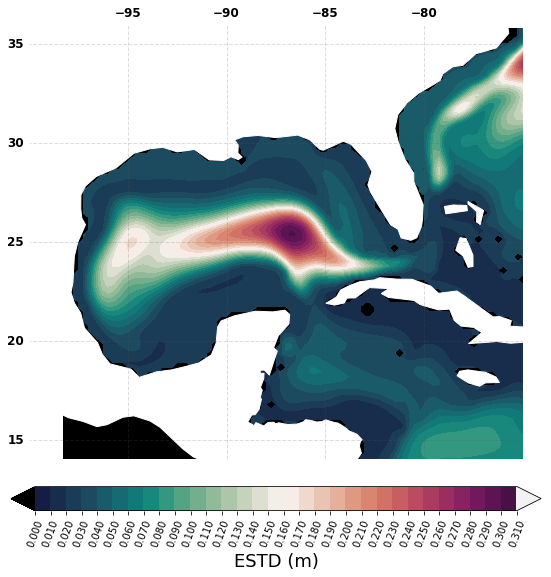

In [131]:
#==========  type of plot =========
#typlo='pcolormesh'
typlo='contourf'
#typlo='pcolormesh'



dpifig=400

#========== regional limits of map =========
xlim=(-100,-75)
ylim=(14,36)



#========= Customed colormap ===============
levels = np.arange(0,0.32,0.01)

cm_base=cmocean.cm.curl #cmocean.cm.deep
#cm_base='Spectral_r'

nice_cmap = plt.get_cmap(cm_base)
colors = nice_cmap(np.linspace(0,1,len(levels)))[:]

cmap, norm = from_levels_and_colors(levels, colors, extend='max')

if typlo=="contourf":
    cmap.set_under('k')
    cmap.set_over('#F2F2F2')
if typlo=="pcolormesh":
    cmap.set_under('w')
    cmap.set_over('k')
    
#====================================
# data to plot 
data2plot = TM_ESTD.fillna(-100.)



#====================================
# output plot type and file name 
if typlo=="pcolormesh":
    plto = "ESTD_SSH_pix"

else:
    plto = "ESTD_SSH"




#----------------------------------------------------
#------ PLOT ----------------------------------------
#----------------------------------------------------

# create fig
fig3 = plt.figure(figsize=([10,10]),facecolor='white')

# plot function (defined above)

if typlo=="contourf":
    cs = plotmapGMEX(fig3,data2plot,nav_lon.values,nav_lat.values,cmap,norm,plto,coastL=True,coastC=True,incrgridlon=5,incrgridlat=5,xlim=xlim,ylim=ylim,typlo=typlo)

if typlo=="pcolormesh":
    cs = plotmapGMEX(fig3,data2plot,nav_lon.values,nav_lat.values,cmap,norm,plto,coastL=False,coastC=False,incrgridlon=5,incrgridlat=5,xlim=xlim,ylim=ylim,typlo=typlo)
    

#======= ADD colorbar=============
cb = plt.colorbar(cs,pad=0.05, shrink=0.95,
                                extend='both',                   
                                ticks=levels,
                                spacing='uniform',
                                orientation='horizontal')
    
new_tickslabels = ["%.3f" % i for i in levels]
cb.set_ticklabels(levels)
cb.ax.set_xticklabels(new_tickslabels, rotation=70,size=10)
#cb.ax.tick_params(labelsize=12) 
cb.set_label('ESTD (m)',size=18)

# display plot
plt.show()

# Save fig in png, resolution dpi
fig3.savefig(diro+"/"+plto+'.png', facecolor=fig3.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#

# close fig
plt.close(fig3)       

# Search Time at which ESTD becomes greater than threshold 
Reminder: threshold is the TimeMean ESTD computed over the 2002-2012 (the 10 last years)

### Step 1: 

Replace all values smaller than the threshold criterium by -10 (i.e. replace values when the threshold has not yet been reached)

In [68]:
# !! Note: (this cell might take a couple of minutes to run)
frac=0.95
%timeit
ESTDsearchmax = ESTD.where(ESTD>frac*TM_ESTD, other=-10., drop=False)


### Step 2:

* Loop on timesteps and replace values that are not -10 by their timestep value (in days)
* Then look for the min value --> gives the first  timestep where the value was greater than the threshold 

In [71]:
# loop on all time steps
for it in range(0,ESTD.time_counter.size):
    # select each time step
    test = ESTDsearchmax.isel(time_counter=it)
    # if values are not -10, then replace by it (it is the timestep (i.e. day))
    test = test.where(test<=-10.,it)
    # replace value in intial search array
    ESTDsearchmax[it,:,:]=test

# Now search for the min it value (that is not -10, obviously): the samller it value is the first time step at which ESTD was greater than thresholdf
timesearched = ESTDsearchmax.where(ESTDsearchmax>-10.,drop=False).min(dim='time_counter')


### Plot Time at which threshold is reached:

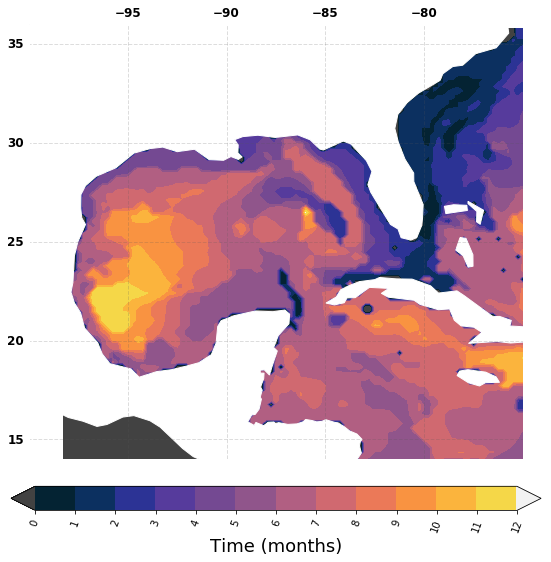

In [137]:
#==========  type of plot =========
#typlo='pcolormesh'
typlo='contourf'
#typlo='pcolormesh'



dpifig=400

#========== regional limits of map =========
xlim=(-100,-75)
ylim=(14,36)



#========= Customed colormap ===============
levels = np.arange(0,365,30)

cm_base=cmocean.cm.thermal #cmocean.cm.deep
#cm_base='Spectral_r'

nice_cmap = plt.get_cmap(cm_base)
colors = nice_cmap(np.linspace(0,1,len(levels)))[:]

cmap, norm = from_levels_and_colors(levels, colors, extend='max')

if typlo=="contourf":
    cmap.set_under('#424242')
    cmap.set_over('#F2F2F2')
if typlo=="pcolormesh":
    cmap.set_under('w')
    cmap.set_over('#F2F2F2')
    
#====================================
# data to plot 
data2plot = timesearched.fillna(-100.)



#====================================
# output plot type and file name 


if typlo=="pcolormesh":
    plto = "TIMESAT_SSH_pix"

else:
    plto = "TIMESAT_SSH"




#----------------------------------------------------
#------ PLOT ----------------------------------------
#----------------------------------------------------

# create fig
fig3 = plt.figure(figsize=([10,10]),facecolor='white')

# plot function (defined above)

if typlo=="contourf":
    cs = plotmapGMEX(fig3,data2plot,nav_lon.values,nav_lat.values,cmap,norm,plto,coastL=True,coastC=True,incrgridlon=5,incrgridlat=5,xlim=xlim,ylim=ylim,typlo=typlo)

else:
    cs = plotmapGMEX(fig3,data2plot,nav_lon.values,nav_lat.values,cmap,norm,plto,coastL=False,coastC=False,incrgridlon=5,incrgridlat=5,xlim=xlim,ylim=ylim,typlo=typlo)
    
#======= colorbar=============
cb = plt.colorbar(cs,pad=0.05, shrink=0.95,
                                extend='both',                   
                                ticks=levels,
                                spacing='uniform',
                                orientation='horizontal')
    
new_tickslabels = ["%.0f" % i for i in levels/30.]
cb.set_ticklabels(levels)
cb.ax.set_xticklabels(new_tickslabels, rotation=70,size=10)
#cb.ax.tick_params(labelsize=12) 
cb.set_label('Time (months)',size=18)

# display plot
plt.show()

# Save fig in png, resolution dpi
fig3.savefig(diro+"/"+plto+'.png', facecolor=fig3.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#

# close fig
plt.close(fig3)       